<div class="alert alert-block alert-info">
    <img style="float: right;" src="https://raw.githubusercontent.com/OpenSourceEconomics/ose-corporate-design/master/logos/OSE_logo_RGB.svg" width="150">
    <u><h1>respy showcase</h1></u>
</div>

In [1]:
import io
import copy
import yaml
import numpy as np
import pandas as pd
import respy as rp
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from pathlib import Path

from auxiliary.auxiliary import *

 ### Outline

 1.  <span style="color:#2C68B9">Package overview</span>  
 2.  Introductory tutorial  
  2.1. Theoretical Framework  
  2.2. Specifying a model  
  2.3. Simulating data  
  2.4. Extending the model  
 3. Pre-implemented example models
 4. Outlook

<div class="alert alert-block alert-info">
    <u><h2>1. Package overview</h2></u>
</div>


### What is **respy**?

- open source Python framework
- simulation and estimation of some finite-horizon discrete choice dynamic programming models 
- class of models: Eckstein-Keane-Wolpin models (Aguirregabiria & Mira, 2009)


### Class of models

- Eckstein-Keane-Wolpin models
- discrete choice dynamic life-cycle framework
- reward function structure: experience accumulation and wages
- economic applications: human capital investments, labor supply, occupational choice


**Model components**
- (any) number of choices and periods
- initial conditions: lagged choices, initial experience, observable characteristics
- unobserved heterogeneity: finite mixture models (types)
- measurement error

### Use cases

**For research ...**
- flexible model specification
- build and solve structural models in weeks or months
- extensive test suite

**For learning & teaching ...**
- extensive online documentation: tutorials, explanations, how-to guides
- variety of pre-implemented example models that scale from toy examples to full empirical models
- sandbox for theses & student projects
- lecture materials: https://ekw-lectures.readthedocs.io

### Steps of modeling

 1. Theoretical development  
 2. <span style="color:#2C68B9">Model implementation</span>  
     2.1. <span style="color:#2C68B9">Specification</span>    
     2.2. <span style="color:#2C68B9">Solution</span>    
     2.3. <span style="color:#2C68B9">Simulation</span>    
 3. <span style="color:#2C68B9">Calibration</span>  
      3.1. <span style="color:#2C68B9">Likelihood- or simulation-based criterion</span>    
      3.2. Optimization $\rightarrow$ [estimagic](https://estimagic.readthedocs.io/en/latest/)  
 4. <span style="color:#2C68B9">Validation and policy evaluation</span> 

### Source code & documentation

- developed on GitHub: https://github.com/OpenSourceEconomics/respy


- online documentation: https://respy.readthedocs.io


**Installation via conda**



```bash
$ conda config --add channels conda-forge
$ conda install -c opensourceeconomics respy
```

#### Source code on GitHub: https://github.com/OpenSourceEconomics/respy

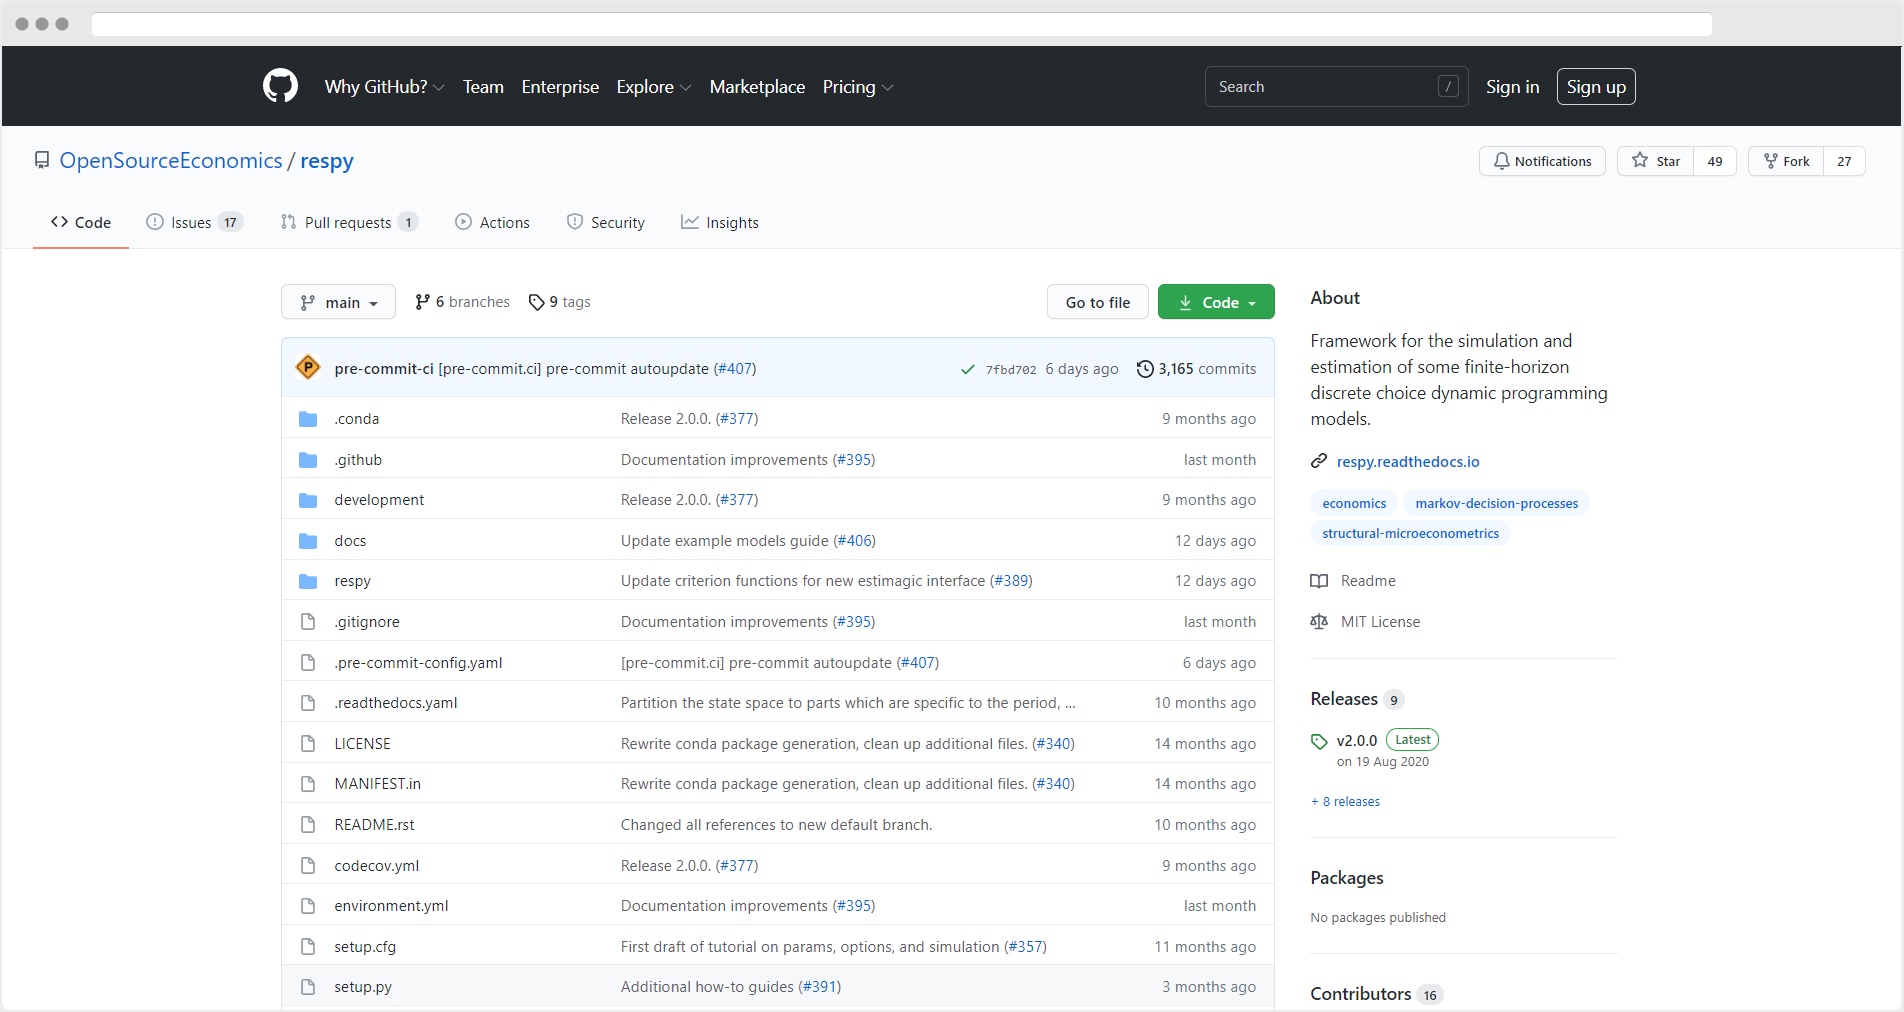

In [2]:
Image(filename='figures/respy-github.png')

#### Testing

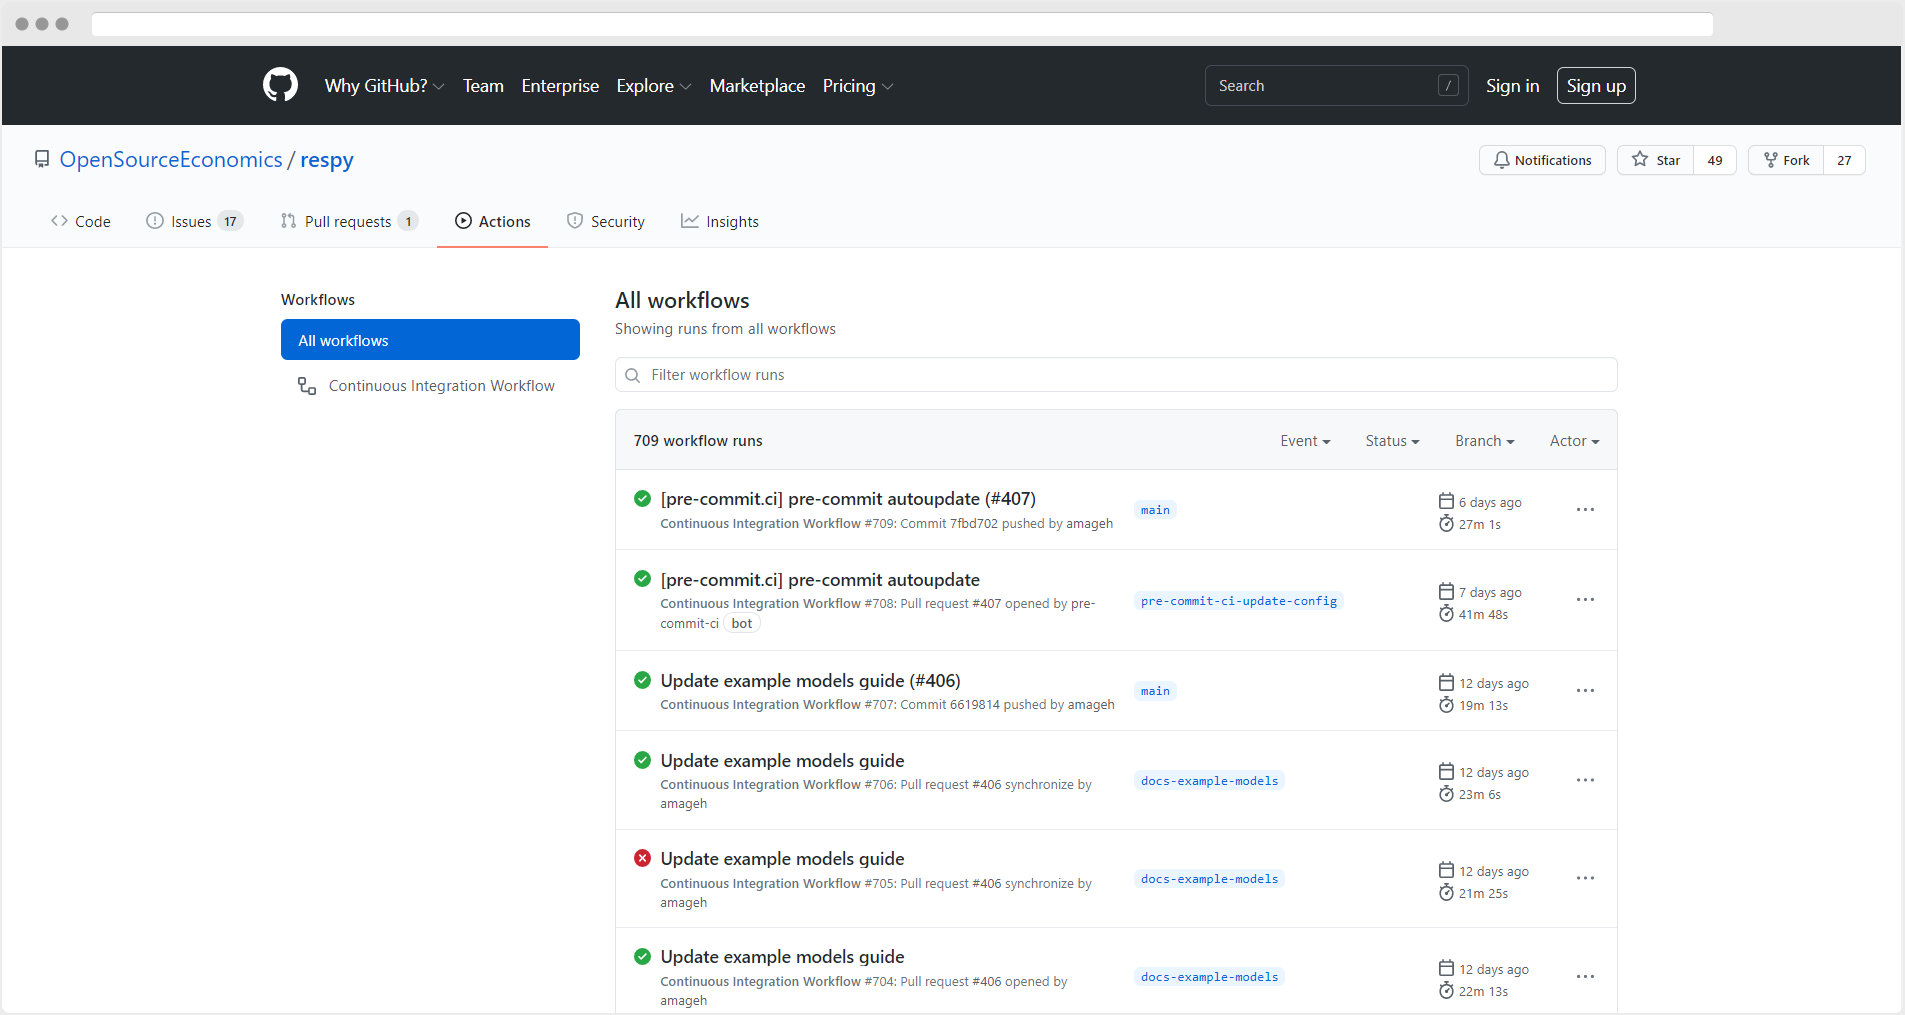

In [3]:
Image(filename='figures/respy-ci.png')

#### Online documentation: https://respy.readthedocs.io

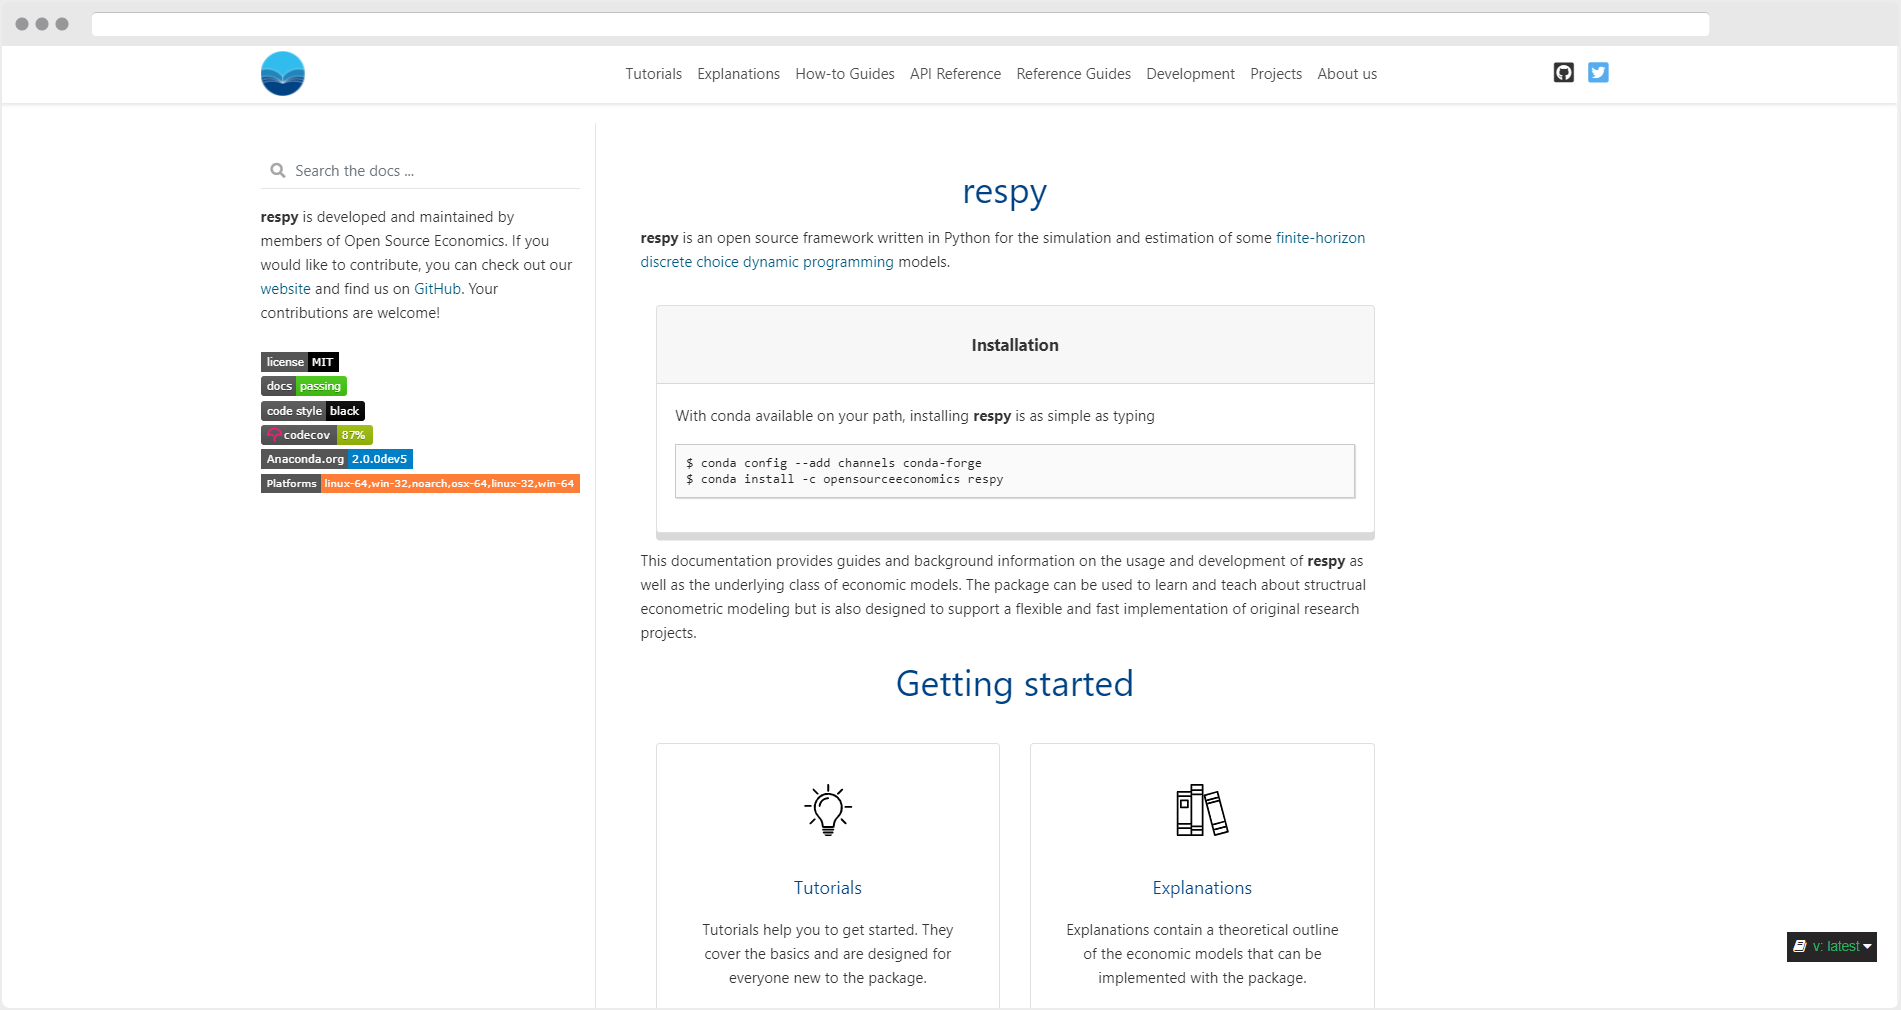

In [4]:
Image(filename='figures/respy-docs.png')

 ### Outline

 1.  Package overview  
 2.  <span style="color:#2C68B9">Introductory tutorial</span>  
  2.1. Theoretical framework  
  2.2. Specifying a model  
  2.3. Simulating data  
  2.4. Extending the model  
 3. Pre-implemented example models
 4. Outlook

<div class="alert alert-block alert-info">
    <u><h2>2. Introductory tutorial</h2></u>
</div>

### Situational setup
- Robinson Crusoe is stranded on a small island.
- He goes fishing to make ends meet and will relax in his hammock when he is tired.
- He cannot relax to often as he won't be able to eat otherwise.
- The more he fishes, the better his fishing skills become.

<div class="alert alert-block alert-warning">
    <u><h3>2.1. Theoretical Framework: Robinson Crusoe on an island</h3></u>
</div>

### The economic problem

- Robinson chooses every period $t = 0, \dots, T$ to either go fishing, $a = 0$, or spend the day in the hammock, $a = 1$.

- If Robinson chooses to go fishing, he gains one additional unit of **experience** in the next period. Experience starts at zero.

- The utility of a choice, $U(s_t, a_t)$, depends on the state $s_t$, which contains information on the individual's characteristics, and the chosen alternative $a_t$.

- Robinson's utility for any given option can be denoted by

$$\begin{align}
    U(s_t, a_t) = \underbrace{W(s_t, a_t)}_{wage} + \underbrace{N(s_t, a_t)}_{non-pecuniary}
\end{align}
$$

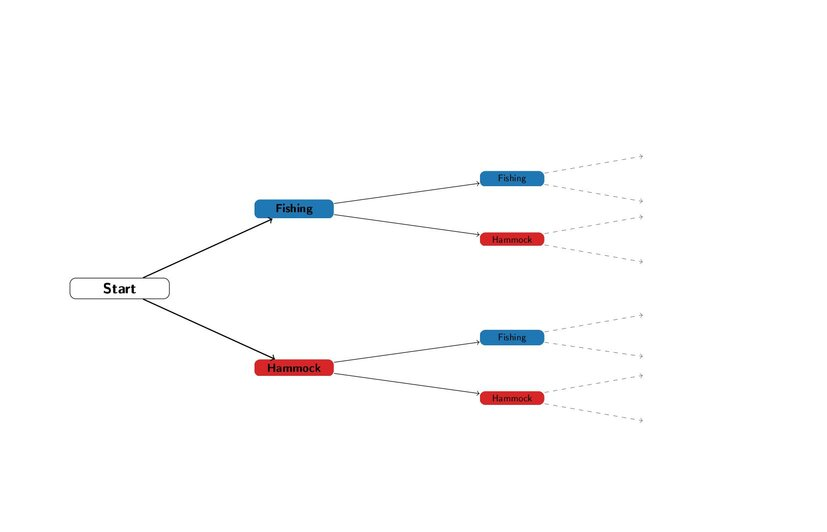

In [5]:
Image(filename="figures/tree_small.jpg")

### Working alternatives

- For working alternatives like fishing, utility consists of two components, a *wage* and a *non-pecuniary* component.

**Wage** 

$$\begin{align}
        W(s_t, a_t)  &= r_{a} \exp\{x^w_{at} \beta^w_a + \epsilon_{at}\}\\
    \ln(W(s_t, a_t)) &= \ln(r_a) + x^w_{at} \beta^w_a + \epsilon_{at}
\end{align}$$

- Components:
    - $r_a$ is a market rental price for skill units.
    
    - $x^w_{at}$ and $\beta^w_a$ are the choice- and time-dependent covariates and returns related to the wage signaled by superscript $w$. 
    
    - $\epsilon_{at}$ is a choice-specific random shock from the shock vector $\epsilon_t \sim \mathcal{N}(0, \Sigma)$ for all choices.

**Non-pecuniary rewards** (for working alternatives)

- Vector dot product of covariates $x_t^w$ and parameters $\beta^w$. 
- Superscript $w$ signals that the components belong to working alternatives.

$$\begin{align}
    N^w(s_t, a_t) = x_t^w\beta^w
\end{align}$$

### Non-working alternatives

**Wage**
$$\begin{align}
W(s_t, a_t) = 0
\end{align}$$

**Non-pecuniary rewards**

- Shocks enter the equation *additively*


- Superscript $n$ stands for non-pecuniary
$$
    N^n(s_t, a_t) = x_t^n\beta^n + \epsilon_{at}
$$

- Robinson's choice set thus consists of a "working" alternative which awards him a pecuniary compensation or wage and a "leisure" or non-working alternative which he derives a utility from, but no experience or wage. Experience in this basic model starts at zero and increases by one for every period $t$ in $1, ..., T$ where he chooses to go fishing. 

### Robinson's choice problem

- Robinson is forward-looking and maximizes the expected present value of utility over the remaining lifetime  $\rightarrow$ select the optimal sequence of choices $\{a_t\}^T_{t = 0}$.


- **Bellman equation**

$$\begin{align}
    V(s_{t})&= \max_{a_t} \, \{\underbrace{U(s_t, a_t)}_{\text{flow utility}}+ \delta \underbrace{\text{E}[ V(s_{t+1})]\}}_{\text{continuation value}}
\end{align}$$

- Realization of shocks becomes known in each period before Robinson makes his choice.
- As shocks in period $t + 1$ are unknown to the individual in period $t$, utility must be maximized given the joint distribution of shocks in period $t + 1$ which is a maximization problem over a two-dimensional integral.

- Denote the non-stochastic part of a state as $s^-$. Then, Robinson maximizes.

$$\begin{equation}
    V(s_t) = \max_{a_t}\{
        U(s_t, a_t) + \delta \int_{\epsilon_{1, t + 1}} \int_{\epsilon_{0, t + 1}}
        \max_{a_{t + 1}} V_{a_{t + 1}}(s^-_{t + 1}, \epsilon_{t + 1})
        f_\epsilon(\epsilon_{t + 1})
        d_{\epsilon_{0, t + 1}}, d_{\epsilon_{1, t + 1}}
    \}
\end{equation}$$

 ### Outline

 1.  Package overview  
 2.  Introductory tutorial  
  2.1. Theoretical framework  
  2.2. <span style="color:#2C68B9">Specifying a model</span>  
  2.3. Simulating data  
  2.4. Extending the model  
 3. Pre-implemented example models
 4. Outlook

<div class="alert alert-block alert-warning">
    <u><h3>2.2. Specifying the model</h3></u>
</div>

**respy** models consists of two main inputs:

- `params`: (estimable) model parameters


- `options` : model settings (number of periods, implementation details) 


### Model parameters: ``params``

- Parameter vector of the model


- Specified as a [MultiIndex pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html) with two index levels.
    1. *category*: which indicates certain parameters groups
    2. *name*: which indicates a specific parameter
    

- read in parameters from a .csv-file:

In [6]:
params = """category,name,value
delta,delta,0.95
wage_fishing,exp_fishing,0.1
nonpec_fishing,constant,-1
nonpec_hammock,constant,2.5
nonpec_hammock,not_fishing_last_period,-1
shocks_sdcorr,sd_fishing,1
shocks_sdcorr,sd_hammock,1
shocks_sdcorr,corr_hammock_fishing,-0.2
lagged_choice_1_hammock,constant,1
"""

In [7]:
params_basic = pd.read_csv(
    io.StringIO(params), sep=",", index_col=["category", "name"]
)

params_basic

value
category                name                          
delta                   delta                     0.95
wage_fishing            exp_fishing               0.10
nonpec_fishing          constant                 -1.00
nonpec_hammock          constant                  2.50
                        not_fishing_last_period  -1.00
shocks_sdcorr           sd_fishing                1.00
                        sd_hammock                1.00
                        corr_hammock_fishing     -0.20
lagged_choice_1_hammock constant                  1.00

### Model options: ``options``

-  dictionary which contains additional information
    - number of periods in the model
    - size of the simulated sample
    - implementation details like seeds
    - covariates

In [8]:
options_basic = {
    "n_periods": 10,
    "simulation_agents": 1000,
    "simulation_seed": 123,
    "covariates": {
        "constant": "1",
        "not_fishing_last_period": "lagged_choice_1 != 'fishing'",
    },
}
options_basic

{'n_periods': 10,
 'simulation_agents': 1000,
 'simulation_seed': 123,
 'covariates': {'constant': '1',
  'not_fishing_last_period': "lagged_choice_1 != 'fishing'"}}

 ### Outline

 1.  Package overview  
 2.  Introductory tutorial  
  2.1. Theoretical framework  
  2.2. Specifying a model  
  2.3. <span style="color:#2C68B9">Simulating data</span>  
  2.4. Extending the model  
 3. Pre-implemented example models
 4. Outlook

<div class="alert alert-block alert-warning">
    <u><h3>2.3. Simulating data</h3></u>
</div>

Using the `params` and `options` we can set up a simulator using the function `get_simulate_func` and subsequently simulate a data for our selected parametrization.

In [9]:
simulate = rp.get_simulate_func(params_basic, options_basic)
df_basic = simulate(params_basic)
df_basic.head(5)

Experience_Fishing Lagged_Choice_1  Shock_Reward_Fishing  \
Identifier Period                                                             
0          0                        0         hammock              0.428556   
           1                        1         fishing              0.780145   
           2                        1         hammock              2.063393   
           3                        2         fishing             -1.190336   
           4                        3         fishing             -0.049084   

                   Meas_Error_Wage_Fishing  Shock_Reward_Hammock  \
Identifier Period                                                  
0          0                             1              0.427466   
           1                             1              1.850937   
           2                             1              0.708209   
           3                             1             -2.028002   
           4                             1              0.607816   

                   Meas_Error_Wage_Hammock  Dense_Key  Core_Index   Choice  \
Identifier Period                                                            
0          0                             1          0           1  fishing   
           1                             1          1           0  hammock   
           2                             1          2           0  fishing   
           3                             1          3           4  fishing   
           4                             1          4           5  hammock   

                       Wage  ...  Nonpecuniary_Reward_Fishing  Wage_Fishing  \
Identifier Period            ...                                              
0          0       1.535039  ...                           -1      1.535039   
           1            NaN  ...                           -1      2.411250   
           2       8.700606  ...                           -1      8.700606   
           3       0.371452  ...                           -1      0.371452   
           4            NaN  ...                           -1      1.285202   

                   Flow_Utility_Fishing  Value_Function_Fishing  \
Identifier Period                                                 
0          0                   0.535039               19.006626   
           1                   1.411250               19.104983   
           2                   7.700606               23.415469   
           3                  -0.628548               13.904880   
           4                   0.285202               13.405278   

                   Continuation_Value_Fishing  Nonpecuniary_Reward_Hammock  \
Identifier Period                                                            
0          0                        19.443776                          1.5   
           1                        18.624982                          2.5   
           2                        16.541961                          1.5   
           3                        15.298346                          2.5   
           4                        13.810606                          2.5   

                   Wage_Hammock  Flow_Utility_Hammock  Value_Function_Hammock  \
Identifier Period                                                               
0          0                NaN              1.833118               18.704274   
           1                NaN              4.157512               20.273393   
           2                NaN              1.781221               16.030649   
           3                NaN              0.751039               13.874853   
           4                NaN              3.105353               14.884157   

                   Continuation_Value_Hammock  
Identifier Period                              
0          0                        17.759111  
           1                        16.964086  
           2                        14.999397  
           3                        13.814541  
           4  

**Choice shares**

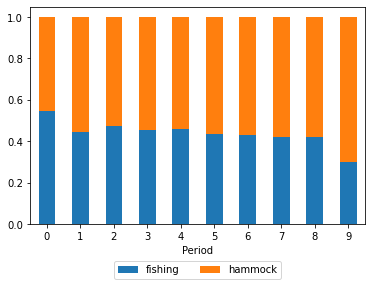

In [10]:
plot_choice_shares(df_basic)

**Transition matrix**

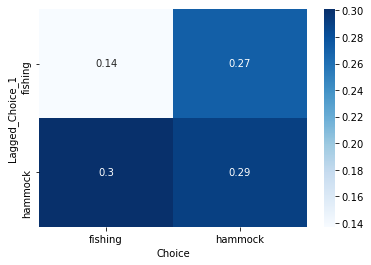

In [11]:
data = pd.crosstab(df_basic.Lagged_Choice_1, df_basic.Choice, normalize=True)
sns.heatmap(data, cmap="Blues", annot=True);

 ### Outline

 1.  Package overview  
 2.  Introductory tutorial  
  2.1. Theoretical framework  
  2.2. Specifying a model  
  2.3. Simulating data  
  2.4. <span style="color:#2C68B9">Extending the model</span>  
 3. Pre-implemented example models
 4. Outlook

<div class="alert alert-block alert-warning">
    <u><h3>2.4. Extending the Model</h3></u>
</div>

<div class="alert alert-block alert-success">
    <u><h4>2.4.1. Extension: Covariates</h4></u>
</div>

**Covariates in the basic model**

1. The constant, which is the simplest covariate
2. The indicator whether Robinson went fishing last period.

**New covariate:** *age*

- assume Robinson's return to fishing decreases as he gets older.
- assume that he arrives at the island with 16 years. 
- assume his age in each period, which we assume for now is one year, increases by one.

I. Edit ``params``

In [12]:
params_age = params_basic.copy()
params_age.loc[("wage_fishing", "age"), "value"] = -0.08
params_age

value
category                name                          
delta                   delta                     0.95
wage_fishing            exp_fishing               0.10
nonpec_fishing          constant                 -1.00
nonpec_hammock          constant                  2.50
                        not_fishing_last_period  -1.00
shocks_sdcorr           sd_fishing                1.00
                        sd_hammock                1.00
                        corr_hammock_fishing     -0.20
lagged_choice_1_hammock constant                  1.00
wage_fishing            age                      -0.08

II. Edit ``options``

In [13]:
options_age = copy.deepcopy(options_basic)
options_age["covariates"].update({"age": "period + 16"})
options_age

{'n_periods': 10,
 'simulation_agents': 1000,
 'simulation_seed': 123,
 'covariates': {'constant': '1',
  'not_fishing_last_period': "lagged_choice_1 != 'fishing'",
  'age': 'period + 16'}}

III. Simulate again

In [14]:
simulate = rp.get_simulate_func(params_age, options_age)
df_age = simulate(params_age)

$\rightarrow$ **Result:** Including the negative effect of age reduces the proportion of individuals that choose fishing, increasingly so in later periods.

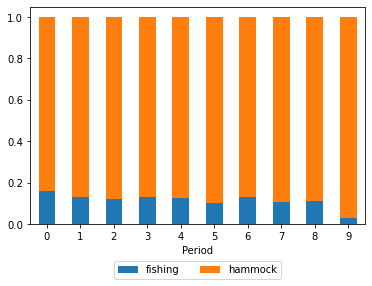

In [15]:
plot_choice_shares(df_age)

<div class="alert alert-block alert-success">
    <u><h4>2.4.2. Extension: Adding Choices</h4></u>
</div>

- after some time on the island, Robinson meets Friday who can help him improve his fishing.

- add the choice alternative `"friday"`

    - affects the utility of fishing. 
    - choice should be available only once starting with the third period, and only after Robinson has been fishing before. 

I. Edit `params` (loaded from .csv)

- `wage_fishing` now includes a return to contemplation with Friday.
- There is a new category,`nonpec_friday`, which captures the non-pecuniary reward for of spending a period with Friday.
- The shock shock variance-covariance matrix has been altered to include the additional option. 


In [16]:
params_friday = pd.read_csv("params_files/robinson_crusoe_friday.csv", index_col=["category", "name"])
params_friday

value
category                name                            
delta                   delta                       0.95
wage_fishing            exp_fishing                 0.10
                        contemplation_with_friday   0.40
nonpec_fishing          constant                   -1.00
nonpec_friday           constant                   -1.00
                        not_fishing_last_period    -1.00
nonpec_hammock          constant                    2.50
                        not_fishing_last_period    -1.00
shocks_sdcorr           sd_fishing                  1.00
                        sd_friday                   1.00
                        sd_hammock                  1.00
                        corr_friday_fishing         0.00
                        corr_hammock_fishing        0.00
                        corr_hammock_friday         0.00
lagged_choice_1_hammock constant                    1.00

II. Adjust `options`

**Covariates**
- new covariate `"contemplation_with_friday"` is only affecting utility if ..
    - Robinson is experienced in fishing
    - only for one interaction with Friday

In [17]:
options_friday = yaml.safe_load(open("option_files/options_friday.yml"))
options_friday["covariates"]

{'constant': '1',
 'contemplation_with_friday': 'exp_friday == 1 and exp_fishing >= 1',
 'not_fishing_last_period': "lagged_choice_1 != 'fishing'"}

**Negative choice set**
- `"negative_choice_set"` can be used to restrict the choice Friday to the third and following periods

In [18]:
options_friday["negative_choice_set"]

{'friday': ['period < 2', 'exp_fishing == 0']}

III. Simulate

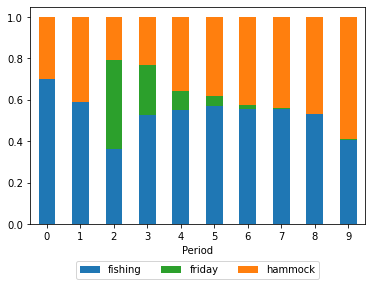

In [19]:
simulate = rp.get_simulate_func(params_friday, options_friday)
df_friday = simulate(params_friday)
plot_choice_shares(df_friday, friday=True)

<div class="alert alert-block alert-success">
    <u><h4>2.4.3. Extension: Initial Experience</h4></u>
</div>

- example of initial conditions: characteristics individuals enter the model with


- assume in period $t=0$, Robinson will have $0$, $1$, or $2$ periods of experience in fishing.


- this introduces a source of heterogeneity between agents

I. Edit `params`

- specify the distribution of initial experience via **probability mass functions**

- keyword is `"initial_exp_fishing_*"` in the *category*-level of the index, where the asterisk needs to be replaced with the experience level. 

- the *name*-level, use `"probability"` to signal that the float in `"value"` is a probability. 

- specification: Robinson has equal probability to start out with 0, 1 or 2 periods of experience.

In [20]:
params_initial_exp = params_basic.copy()
params_initial_exp.loc[ ("initial_exp_fishing_0", "probability"), "value"] = 0.33
params_initial_exp.loc[("initial_exp_fishing_1", "probability"), "value"] = 0.33
params_initial_exp.loc[ ("initial_exp_fishing_2", "probability"), "value"] = 0.34
params_initial_exp

value
category                name                          
delta                   delta                     0.95
wage_fishing            exp_fishing               0.10
nonpec_fishing          constant                 -1.00
nonpec_hammock          constant                  2.50
                        not_fishing_last_period  -1.00
shocks_sdcorr           sd_fishing                1.00
                        sd_hammock                1.00
                        corr_hammock_fishing     -0.20
lagged_choice_1_hammock constant                  1.00
initial_exp_fishing_0   probability               0.33
initial_exp_fishing_1   probability               0.33
initial_exp_fishing_2   probability               0.34

II. Adjust `options`

$\rightarrow$ not necessary in this case!

III. Simulate

In [21]:
simulate = rp.get_simulate_func(params_initial_exp, options_basic)
df_exp = simulate(params_initial_exp)

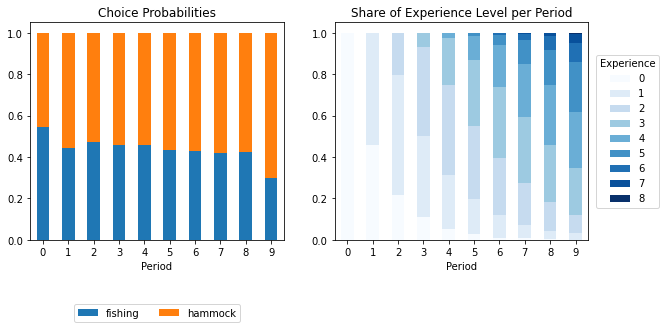

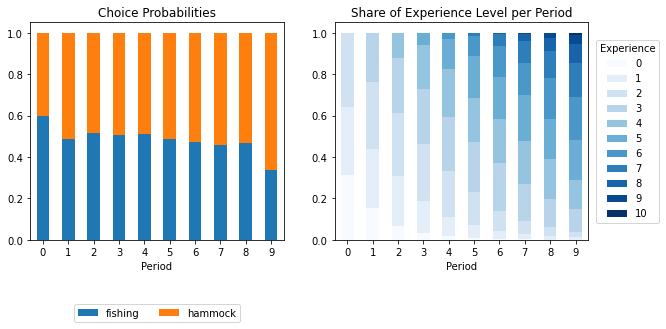

In [22]:
plot_choice_prob_and_exp_level(df_basic)
plot_choice_prob_and_exp_level(df_exp)

Comparing the plots shows that the share of engagement in fishing increases compared to the baseline scenario, as two thirds of Robinsons land on the island with previous experience in fishing. 

<div class="alert alert-block alert-success">
    <u><h4>2.4.4. Extension: Observables</h4></u>
</div>

- add one observable characteristic to the baseline model, `"fishing_grounds"`


- assume Robinson can end up, with a certain probability, on the side of the island which has `"poor"` or `"rich"` fishing grounds.


- experiencing rich fishing grounds affects the **non-pecuniary reward** for fishing. 

I. Add three additional rows to `params`

- The probability with which Robinson will find himself in rich and in poor fishing grounds.

- The return for being in a rich fishing ground, which here is set to be positive and constant.

In [23]:
params_fish_ground = params_basic.copy()
params_fish_ground.loc[("observable_fishing_grounds_rich", "probability"), "value"] = 0.5
params_fish_ground.loc[("observable_fishing_grounds_poor", "probability"), "value"] = 0.5
params_fish_ground.loc[("nonpec_fishing", "rich_fishing_grounds"), "value"] = 0.5
params_fish_ground

value
category                        name                          
delta                           delta                     0.95
wage_fishing                    exp_fishing               0.10
nonpec_fishing                  constant                 -1.00
nonpec_hammock                  constant                  2.50
                                not_fishing_last_period  -1.00
shocks_sdcorr                   sd_fishing                1.00
                                sd_hammock                1.00
                                corr_hammock_fishing     -0.20
lagged_choice_1_hammock         constant                  1.00
observable_fishing_grounds_rich probability               0.50
observable_fishing_grounds_poor probability               0.50
nonpec_fishing                  rich_fishing_grounds      0.50

II. Adjust covariates in `options`

In [24]:
options_fish_ground = options_basic.copy()
options_fish_ground["covariates"] = {
    "constant": "1",
    "not_fishing_last_period": "lagged_choice_1 != 'fishing'",
    "rich_fishing_grounds": "fishing_grounds == 'rich'",
}
options_fish_ground

{'n_periods': 10,
 'simulation_agents': 1000,
 'simulation_seed': 123,
 'covariates': {'constant': '1',
  'not_fishing_last_period': "lagged_choice_1 != 'fishing'",
  'rich_fishing_grounds': "fishing_grounds == 'rich'"}}

III. Simulate again

In [25]:
simulate = rp.get_simulate_func(params_fish_ground, options_fish_ground)
df_fish_ground = simulate(params_fish_ground)

As can be expected, Robinson engages in fishing more often if he is stranded on the side of the island with rich fishing grounds.

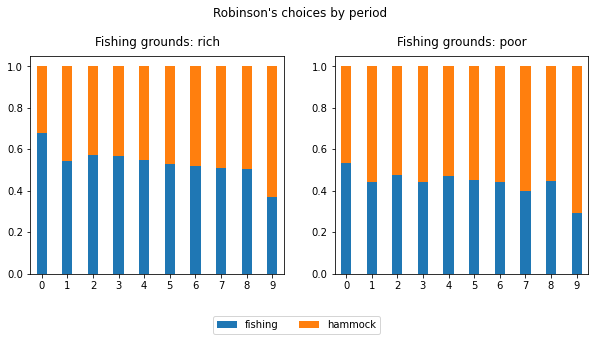

In [26]:
plot_fishing_grounds(df_fish_ground)

 ### Outline

 1.  Package overview  
 2.  Introductory tutorial  
  2.1. Theoretical framework  
  2.2. Specifying a model  
  2.3. Simulating data  
  2.4. Extending the model    
 3. <span style="color:#2C68B9">Pre-implemented example models</span>
 4. Outlook

<div class="alert alert-block alert-info">
    <u><h2>3. Pre-implemented example models</h2></u>
</div>


```python
params, options, data = rp.get_example_model(<model>)
```

### Toy models

- based on the story of Robinson Crusoe

- used in the [tutorials](https://respy.readthedocs.io/en/latest/tutorials/index.html) in the documentation

**Models**

- `robinson_crusoe_basic`

- `robinson_crusoe_extended`


**Advantages**

- simple model structure
- computationally feasible due to the small number of available choices and low number of periods in the models
    
$\rightarrow$ useful of learning & teaching

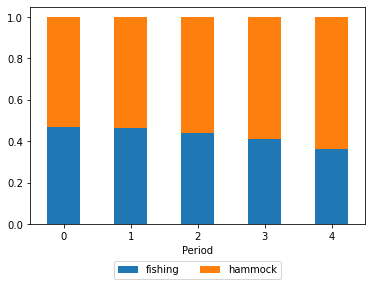

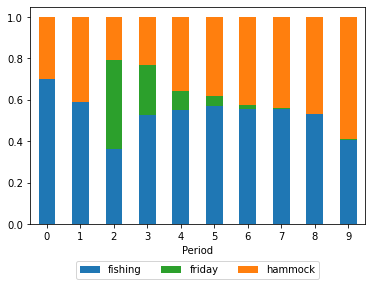

In [27]:
_, _, data = rp.get_example_model("robinson_crusoe_basic")
plot_choice_shares(data)
_, _, data = rp.get_example_model("robinson_crusoe_extended")
plot_choice_shares(data, friday=True)

### Keane and Wolpin (1994)


**Source**

- Keane, M. P., & Wolpin, K. I. (1994). The Solution and Estimation of Discrete Choice Dynamic Programming Models by Simulation and Interpolation: Monte Carlo Evidence. *The Review of Economics and Statistics*, 648-672.

**Characteristics**
- four mutually exclusive alternatives that individuals can choose in each period (work in sectors `a` or `b`, invest in education, or stay home)
- time horizon of 40 periods

**Models**

- `kw_94_one`
- `kw_94_two`
- `kw_94_three`

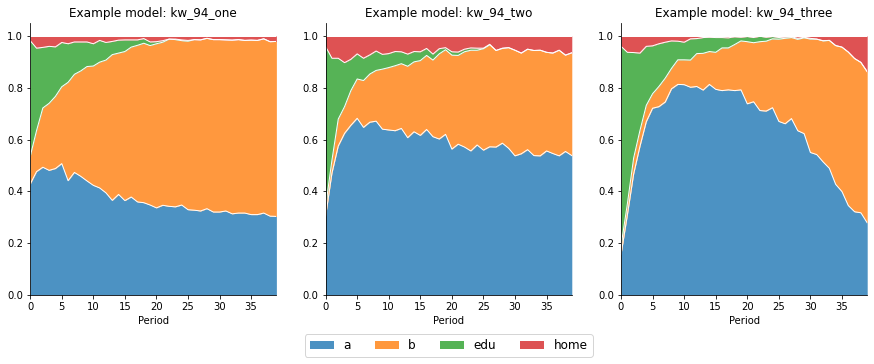

In [28]:
plot_choices_kw(example="1994")

### Keane and Wolpin (1997)

**Source**

* Keane, M. P., & Wolpin, K. I. (1997). The Career Decisions of Young Men. *Journal of Political Economy*, 105(3), 473-522.

**Characteristics**

* five mutually exclusive choice alternatives (occupations `white-collar`, `blue-collar`, `military`, school and staying home)
* basic and extended model specification with unobserved heterogeneity, measurement error, and initial experience
* time horizon of 50 periods
* empirical model calibrated to a sample of white men in the National Longitudinal Survey of Youth (NLSY)

**Models**

- `kw_97_basic`

- `kw_97_extended`


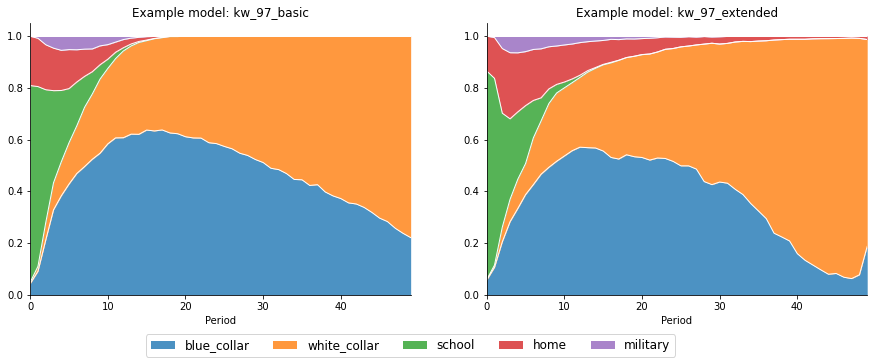

In [29]:
plot_choices_kw(example="1997")

### Keane and Wolpin (2000)

**Source**

- Keane, M. P., & Wolpin, K. I. (2000). Eliminating Race Differences in School Attainment and Labor Market Success. *Journal of Labor Economics*, 18(4), 614-652.

**Model**

- `kw_2000`

The model is very similar to the extended model specification in Keane and Wolpin (1997).

 ### Outline

 1.  Package overview  
 2.  Introductory tutorial  
  2.1. Theoretical framework  
  2.2. Specifying a model  
  2.3. Simulating data  
  2.4. Extending the model    
 3. Pre-implemented example models
 4. <span style="color:#2C68B9">Outlook</span>

<div class="alert alert-block alert-info">    
    <u><h2>4. Outlook</h2></u>
</div>

#### Recent advancements

- Exogenous processes (childbirth, health shocks etc.)
- Revision of the state space
- State specific choice sets

#### Potential
- Consumption and saving decisions
- Continuous choices or time

### Related software projects

- [`estimagic`](https://estimagic.readthedocs.io/en/latest/) is a Python package that provides high-quality and user-friendly tools to fit large scale empirical models to data and make inferences about the estimated model parameters. 

- [`ruspy`](https://ruspy.readthedocs.io/en/latest/) is an open-source Python package for the simulation and estimation of a prototypical infinite-horizon dynamic discrete choice model based on Rust (1987).

- [`grmpy`](https://grmpy.readthedocs.io/en/latest/) is an open-source Python package for the simulation and estimation of the generalized Roy model.

- [`econsa`](https://econsa.readthedocs.io/en/latest/) is an open-source Python package that facilitates uncertainty propagation and global sensitivity of computational economic models.analysis.

- [`robupy`](https://robupy.readthedocs.io/en/latest/) is an open-source Python package for robust decision making.


- [`gettsim`](https://gettsim.readthedocs.io/en/stable/) is an open-source Python package developed by OSE members providing a depiction of the German Taxes and Transfers System.
 

<div class="alert alert-block alert-info">    
    <u><h2>Thank you!</h2></u>
</div>

More information on OpenSourceEconomics software projects at https://open-econ.org.